In [1]:
import keras
from keras.utils import np_utils
import numpy as np
from keras.layers import Activation,Dense,Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [2]:
def lr_schedule(epoch):
    lrate=0.0001
    if epoch > 75:
        lrate=0.0005
    if epoch > 100:
        lrate=0.0003
    return lrate

In [3]:
(xtrain,ytrain),(xtest,ytest)=cifar10.load_data()
xtrain=xtrain.astype('float32')
xtest=xtest.astype('float32')

In [4]:
#z-score - normalization
mean=np.mean(xtrain,axis=(0,1,2,3))
std=np.std(xtrain,axis=(0,1,2,3))
xtrain=(xtrain-mean)/(std+1e-7)
xtest=(xtest-mean)/(std+1e-7)

In [5]:
num_classes=10
ytrain=np_utils.to_categorical(ytrain,num_classes)
ytest=np_utils.to_categorical(ytest,num_classes)

In [6]:
weight_decay=1e-4

In [7]:
model=Sequential()

In [8]:
model.add(Conv2D(32,(3,3), padding='same',kernel_regularizer=regularizers.l2(weight_decay),input_shape=xtrain.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#model.add(Conv2D(64,(3,3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Activation('elu'))
#model.add(BatchNormalization())
#model.add(Conv2D(64,(3,3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Activation('elu'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

In [9]:
datagen=ImageDataGenerator(rotation_range=45,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True)
datagen.fit(xtrain)

In [13]:
#training

batch_size=64
opt_rms=keras.optimizers.rmsprop(lr=0.0001,decay=1e-6)
adam=keras.optimizers.Adam(lr=0.0003)
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
model.fit_generator(datagen.flow(xtrain,ytrain, batch_size=batch_size),steps_per_epoch=xtrain.shape[0] // batch_size,epochs=5,verbose=1,validation_data=(xtest,ytest),callbacks=[LearningRateScheduler(lr_schedule)])


#testing
scores=model.evaluate(xtest, ytest,batch_size=128,verbose=1)
print('\n Test Result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

Epoch 1/5
781/781 [==============================] - 501s 641ms/step - loss: 1.3014 - accuracy: 0.5575 - val_loss: 1.2423 - val_accuracy: 0.5945
Epoch 2/5
781/781 [==============================] - 484s 620ms/step - loss: 1.2626 - accuracy: 0.5731 - val_loss: 1.2345 - val_accuracy: 0.6026
Epoch 3/5
781/781 [==============================] - 474s 607ms/step - loss: 1.2232 - accuracy: 0.5862 - val_loss: 1.1707 - val_accuracy: 0.6292
Epoch 4/5
781/781 [==============================] - 460s 589ms/step - loss: 1.1877 - accuracy: 0.5970 - val_loss: 1.1985 - val_accuracy: 0.6142
Epoch 5/5
10000/10000 [==============================] - 18s 2ms/step

 Test Result: 62.430 loss: 1.179


In [52]:
import matplotlib.pyplot as plt

def show_images(X):
    plt.figure(figsize=(20,10))
    k=0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow((X[k].astype(np.uint8)))
            k+=1
    plt.show()
            

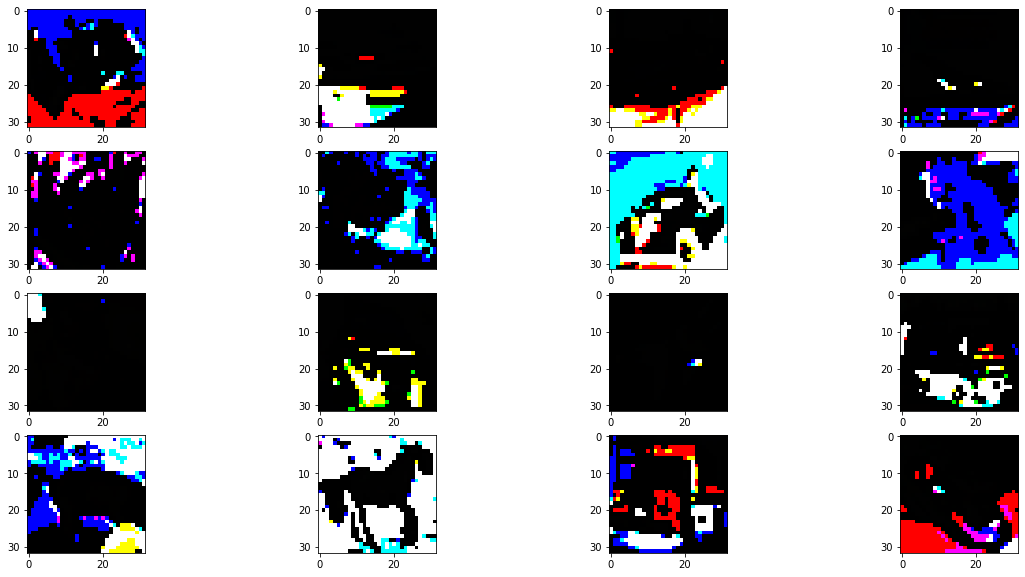

['ship', 'ship', 'ship', 'airplane', 'frog', 'frog', 'truck', 'frog', 'frog', 'automobile', 'ship', 'truck', 'frog', 'horse', 'truck', 'ship']


In [53]:
import warnings
warnings.filterwarnings('ignore')
labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

indices=np.argmax(model.predict(xtest[:16]),1)
show_images(xtest)
print([labels[x] for x in indices])